# **Advanced Particle Mesh Simulation on a Single GPU**

<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/02-Advanced_usage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [ ]:
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!pip install diffrax

In [ ]:
import jax
import jax.numpy as jnp
import jax_cosmo as jc

from jaxpm.painting import cic_paint , cic_paint_dx
from jaxpm.pm import linear_field, lpt, make_diffrax_ode
from jaxpm.distributed import uniform_particles
from diffrax import ConstantStepSize, LeapfrogMidpoint, ODETerm, SaveAt, diffeqsolve

### Particle Mesh Simulation with Diffrax Leapfrog Solver

In this setup, we use the `LeapfrogMidpoint` solver from the `diffrax` library to evolve particle displacements over time in our Particle Mesh simulation. The novelty here is the use of a **Leapfrog solver** from `diffrax` for efficient, memory-saving time integration.

- **Leapfrog Integration**: This symplectic integrator is well-suited for simulations of gravitational dynamics, preserving energy over long timescales and allowing larger time steps without sacrificing accuracy.
- **Efficient Displacement Tracking**: We initialize only displacements (`dx`) rather than absolute positions, which, combined with Leapfrog’s stability, enhances memory efficiency and speeds up computation.


In [ ]:
mesh_shape = [128, 128, 128]
box_size = [128., 128., 128.]
snapshots = jnp.array([0.5, 1.0])

@jax.jit
def run_simulation(omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    # Create particles
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, a=0.1,order=1)
    
    # Evolve the simulation forward
    ode_fn = ODETerm(
        make_diffrax_ode(mesh_shape, paint_absolute_pos=False))
    solver = LeapfrogMidpoint()

    stepsize_controller = ConstantStepSize()
    res = diffeqsolve(ode_fn,
                      solver,
                      t0=0.1,
                      t1=1.,
                      dt0=0.01,
                      y0=jnp.stack([dx, p], axis=0),
                      args=cosmo,
                      saveat=SaveAt(ts=snapshots),
                      stepsize_controller=stepsize_controller)

    ode_solutions = [sol[0] for sol in res.ys]
    return initial_conditions ,  dx , ode_solutions , res.stats

initial_conditions , lpt_displacements , ode_solutions , solver_stats = run_simulation(0.25, 0.8)
ode_solutions[-1].block_until_ready()
%timeit initial_conditions , lpt_displacements , ode_solutions , solver_stats = run_simulation(0.25, 0.8);ode_solutions[-1].block_until_ready()
print(f"Solver Stats : {solver_stats}")

4.05 s ± 1.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Solver Stats : {'max_steps': Array(4096, dtype=int32, weak_type=True), 'num_accepted_steps': Array(90, dtype=int32, weak_type=True), 'num_rejected_steps': Array(0, dtype=int32, weak_type=True), 'num_steps': Array(90, dtype=int32, weak_type=True)}


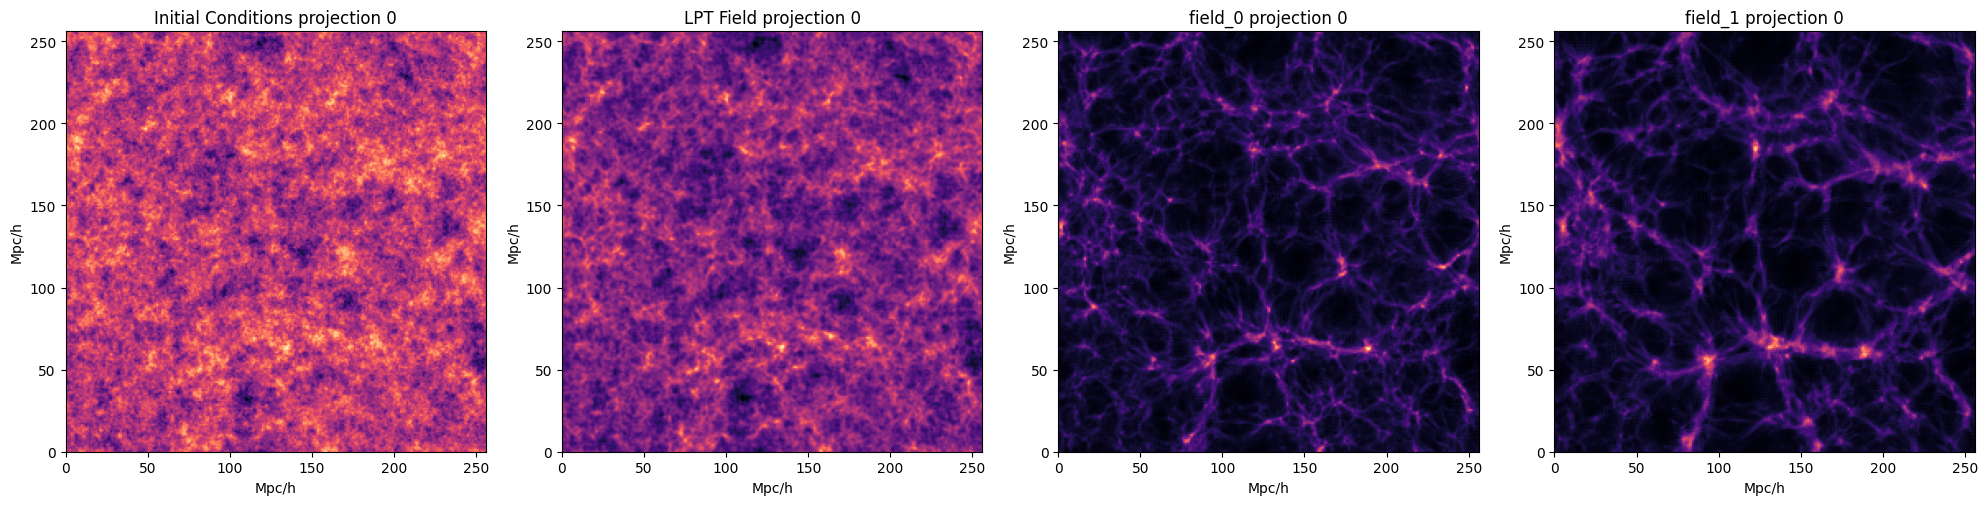

In [ ]:
from jaxpm.plotting import plot_fields_single_projection

fields = {"Initial Conditions" : initial_conditions , "LPT Field" : cic_paint_dx(lpt_displacements)}
for i , field in enumerate(ode_solutions):
    fields[f"field_{i}"] = cic_paint_dx(field)
plot_fields_single_projection(fields)

### First and Second Order Lagrangian Perturbation Theory (LPT) Displacements

This section introduces **first-order and second-order LPT** simulations, controlled by the `order` argument. First-order LPT captures linear displacements, while second-order LPT includes nonlinear corrections, allowing more accurate modeling of structure formation.


In [ ]:
from functools import partial 

mesh_shape = [128, 128, 128]
box_size = [128., 128., 128.]
snapshots = jnp.array([0.5,1.])

@partial(jax.jit , static_argnums=(2,))
def lpt_simulation(omega_c, sigma8, order=1):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    # Create particles
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions, a=0.8,order=order)

    return initial_conditions ,  dx

initial_conditions_1 , lpt_displacements_1 = lpt_simulation(0.25, 0.8 , order=1)
lpt_displacements_1.block_until_ready()
initial_conditions_2 , lpt_displacements_2 = lpt_simulation(0.25, 0.8 , order=2)
lpt_displacements_2.block_until_ready()
%timeit initial_conditions_1 , lpt_displacements_1 = lpt_simulation(0.25, 0.8 , order=1);lpt_displacements_1.block_until_ready()
%timeit initial_conditions_2 , lpt_displacements_2 = lpt_simulation(0.25, 0.8, order=2);lpt_displacements_2.block_until_ready()

32.3 ms ± 9.42 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
42.8 ms ± 9.74 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


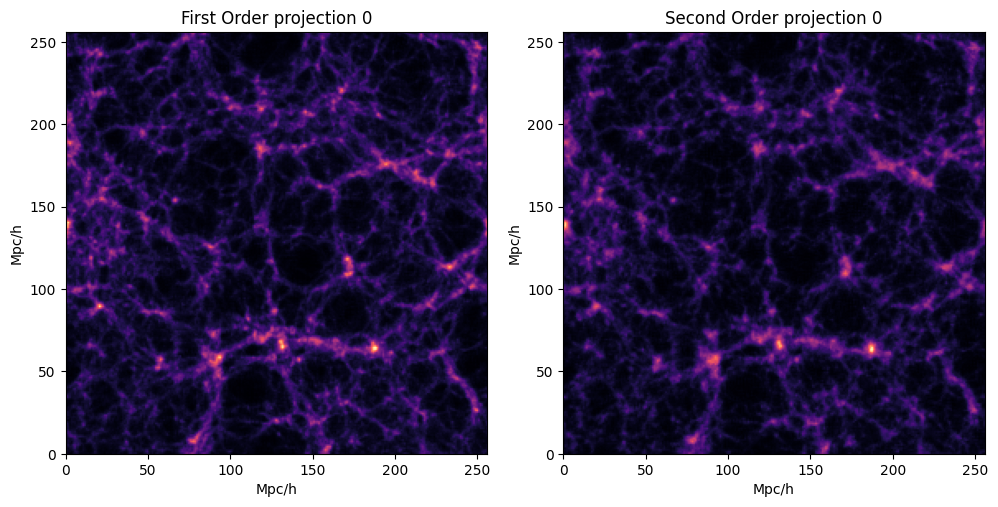

In [5]:
lpt_fields = {"First Order" : cic_paint_dx(lpt_displacements_1) , "Second Order" : cic_paint_dx(lpt_displacements_2)}
plot_fields_single_projection(lpt_fields)

### Custom ODE Solver with Absolute Positions

Just like in the introduction notebook, this example uses **absolute particle positions** initialized on a uniform grid. We evolve these absolute positions forward using a Cloud-in-Cell (CIC) scheme, which enables clear tracking of particle movement across the simulation volume.

Here, we integrate over multiple snapshots with `diffeqsolve` and a **Leapfrog solver**.


In [ ]:
mesh_shape = [128, 128, 128]
box_size = [128., 128., 128.]
snapshots = jnp.array([0.1 ,0.5, 1.])

@jax.jit
def run_simulation(omega_c, sigma8):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(jc.Planck15(Omega_c=omega_c, sigma8=sigma8), k)
    pk_fn = lambda x: jnp.interp(x.reshape([-1]), k, pk).reshape(x.shape)

    # Create initial conditions
    initial_conditions = linear_field(mesh_shape, box_size, pk_fn, seed=jax.random.PRNGKey(0))

    # Create particles
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)
    
    particles = uniform_particles(mesh_shape)
    # Initial displacement
    dx, p, f = lpt(cosmo, initial_conditions,particles=particles,a=0.1,order=2)
    
    # Evolve the simulation forward
    ode_fn = ODETerm(
        make_diffrax_ode(mesh_shape))
    solver = LeapfrogMidpoint()

    stepsize_controller = ConstantStepSize()
    res = diffeqsolve(ode_fn,
                      solver,
                      t0=0.1,
                      t1=1.,
                      dt0=0.2,
                      y0=jnp.stack([particles + dx, p], axis=0),
                      args=cosmo,
                      saveat=SaveAt(ts=snapshots),
                      stepsize_controller=stepsize_controller)

    ode_particles = [sol[0] for sol in res.ys]
    return initial_conditions ,  particles + dx , ode_particles , res.stats

initial_conditions , lpt_particles , ode_particles , solver_stats = run_simulation(0.25, 0.8)
print(f"Solver Stats : {solver_stats}")

Solver Stats : {'max_steps': Array(4096, dtype=int32, weak_type=True), 'num_accepted_steps': Array(5, dtype=int32, weak_type=True), 'num_rejected_steps': Array(0, dtype=int32, weak_type=True), 'num_steps': Array(5, dtype=int32, weak_type=True)}


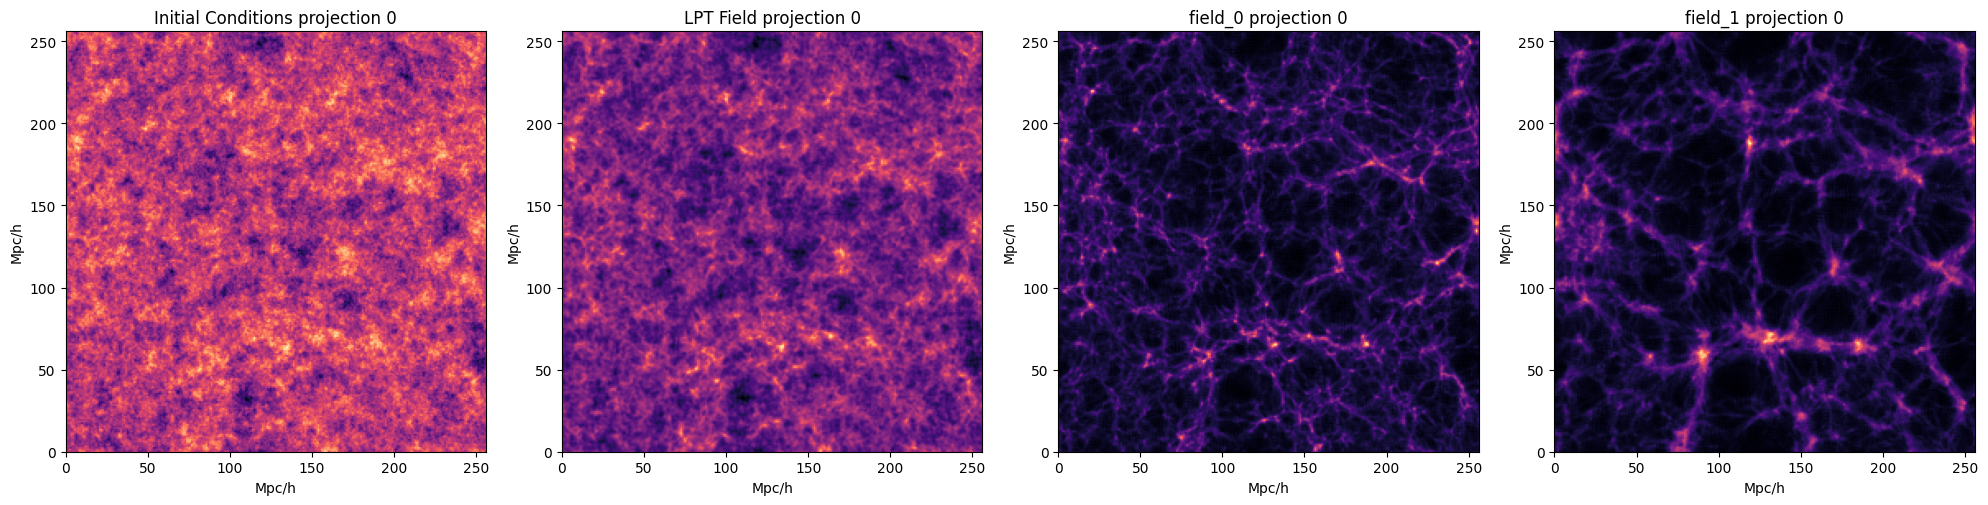

In [ ]:
from jaxpm.plotting import plot_fields_single_projection

fields = {"Initial Conditions" : initial_conditions , "LPT Field" : cic_paint(jnp.zeros(mesh_shape) ,lpt_particles)}
for i , field in enumerate(ode_particles[1:]):
    fields[f"field_{i}"] = cic_paint(jnp.zeros(mesh_shape) , field)
plot_fields_single_projection(fields)

### Weighted Field Projection for Central Region

In this cell, we apply custom weights to enhance density specifically in the **central 3D region** of the grid. By updating weights in this area, we multiply density by a factor of 3, emphasizing the structure in the center of the simulation volume.

We compare:
- **Weighted**: Density increased in the central region.
- **Unweighted**: Standard CIC painting without additional weighting.


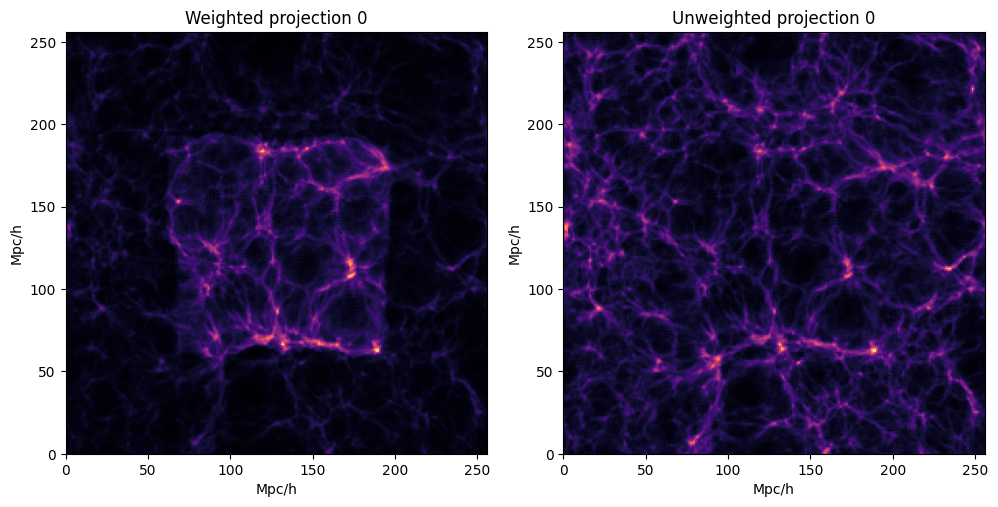

In [ ]:
from jaxpm.plotting import plot_fields_single_projection

center = slice(mesh_shape[0] // 4, 3 * mesh_shape[0] // 4 )
center3d = (slice(None) , center,center) 
weights = jnp.ones_like(initial_conditions)
weights = weights.at[center3d].multiply(3)

weighted = cic_paint_dx(ode_solutions[0], weight=weights)
unweighted = cic_paint_dx(ode_solutions[0] , weight=1.0)

plot_fields_single_projection({"Weighted" : weighted , "Unweighted" : unweighted} , project_axis=0)

### Weighted Field Projection with Absolute Positions

For simulations with absolute positions, we apply a weight factor of **1.3** to the central 3D region. Unlike previous cases using displacements, here the weight affects the absolute particle positions directly, impacting the overall density field differently.


__Note:__ Since the weights apply to absolute positions (not displacements), the result differs, affecting the particle density distribution directly.


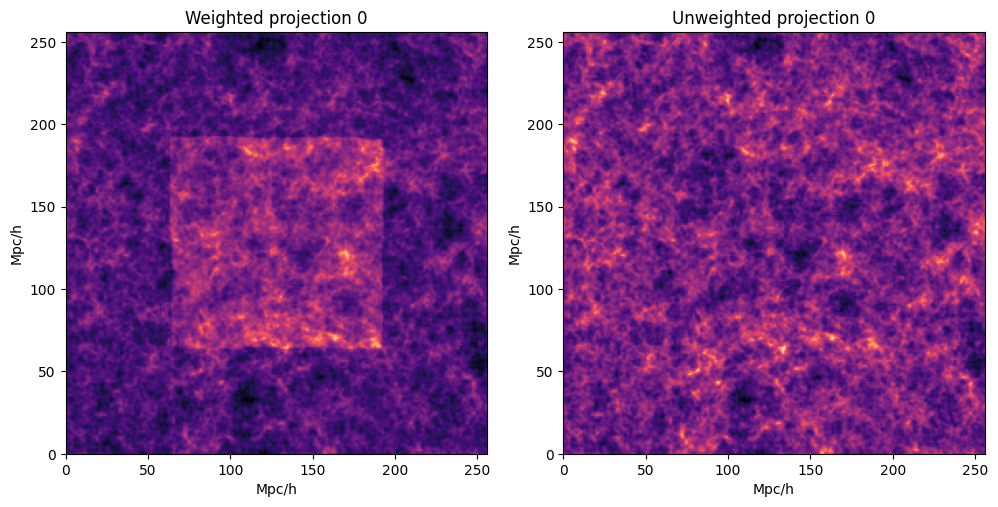

In [ ]:
from jaxpm.plotting import plot_fields_single_projection

center = slice(mesh_shape[0] // 4, 3 * mesh_shape[0] // 4 )
center3d = (slice(None) , center,center)  
weights = jnp.ones_like(initial_conditions)
weights = weights.at[center3d].multiply(1.3)

weighted = cic_paint(jnp.zeros(mesh_shape),ode_particles[0], weight=weights)
unweighted = cic_paint(jnp.zeros(mesh_shape),ode_particles[0] , weight=2.0)

plot_fields_single_projection({"Weighted" : weighted , "Unweighted" : unweighted} , project_axis=0)